# Capstone - Toronto Shelter Occupancy Prediction Model Fitting

## Import Modules

In [94]:
# Basics
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# Decomposing
from sklearn.decomposition import PCA

# Model Evaluations
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Ignore warnings
warnings.filterwarnings("ignore")

In [115]:
# Loading data csv
df = pd.read_csv('data/shelter_occupancy_cleaned.csv').drop(['Unnamed: 0'], axis=1)
coor_df = pd.read_csv('data/shelter_coordinates.csv').drop(['Unnamed: 0'], axis=1)
weather_df = pd.read_csv('data/toronto_weather.csv').drop(['Unnamed: 0'], axis=1)

---

## Preparing Data

In [116]:
# Merging data frames
df = pd.merge(df, coor_df, how='left', on='SHELTER_POSTAL_CODE')
df = pd.merge(df, weather_df, how='left', on='OCCUPANCY_DATE')

In [117]:
# Converting categorical data to dummy variables
df = pd.get_dummies(df, columns=['SECTOR', 'sublocality', 'Week_Day'])

In [118]:
# Dropping unneeded features before fitting
df = df.drop([
    'FACILITY_NAME', 'OCCUPANCY_DATE', 'ORGANIZATION_NAME', 'PROGRAM_NAME', 'SHELTER_ADDRESS', 'SHELTER_CITY',
    'SHELTER_NAME', 'SHELTER_POSTAL_CODE', 'SHELTER_PROVINCE','lat', 'lng', 'OCCUPANCY',
    'Week_Day_Int'
], axis=1)

In [119]:
# Defining occupancy level (dependent variable)
# 1 if occupancy rate is higher than 100%
df['OCCUPANCY_LEVEL'] = df.OCCUPANCY_RATE.apply(lambda x : 1 if x >=1 else 0)
df = df.drop(['OCCUPANCY_RATE'], axis=1)

In [120]:
# It seems that the historical weather data contains null values
df.columns[df.isna().any()]

Index(['Mean Temp (°C)', 'Total Precip (mm)'], dtype='object')

In [121]:
# Dropping rows with null weather data
df.dropna(inplace=True)

In [122]:
# Preparing data for model fitting

# Independent variables are shelter data (capacity, day of the week, location, weather, etc.)
X = df.loc[:, 'CAPACITY':'Week_Day_WED']

# Dependent variable is weather a shelter is full (1 indicates a shelter is full, 0 indicates otherwise)
y = df.OCCUPANCY_LEVEL

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7)

---
## Fitting Models
### Logistic Regression

In [53]:
# Trying to fit a Logistic Regression model with default settings
logit = LogisticRegression().fit(X_train, y_train)
print(f'Accuracy: {logit.score(X_test, y_test)}')

Accuracy: 0.6368167998303047


In [54]:
# Percentage of full and non-full records
y.value_counts() / y.shape[0]

1    0.609166
0    0.390834
Name: OCCUPANCY_LEVEL, dtype: float64

61% of the records in the data reach full occupancy. A accuracy score of 64% is only slightly better than pure chance.

In [55]:
# Precision, Recall & F1 Score 
y_pred = logit.predict(X_test)
print(f'Precision Score: {precision_score(y_test, y_pred)}')
print(f'Recall Score: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')

Precision Score: 0.6518589841783925
Recall Score: 0.8653013798111837
F1 Score: 0.7435660617558224


In [56]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.28      0.38     22147
           1       0.65      0.87      0.74     34425

    accuracy                           0.64     56572
   macro avg       0.61      0.57      0.56     56572
weighted avg       0.62      0.64      0.60     56572



The initial logistic model shows an **F1** score of **0.74**. This will be used as a baseline to compare with other models.

---

### SVM

In [125]:
# Trying an SVM model with data scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

In [126]:
rbf_svc = SVC(kernel='rbf').fit(X_train, y_train)
X_test = scaler.transform(X_test)

y_pred = rbf_svc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.37      0.46     22223
           1       0.68      0.85      0.75     34595

    accuracy                           0.66     56818
   macro avg       0.64      0.61      0.60     56818
weighted avg       0.65      0.66      0.64     56818



The SVM model is able to achieve an **F1** score of **0.66**, which is a minor improvement.

---

### PCA

In [68]:
# Decomposing with PCA
# Selecting the first 90% Principal Components
pca = PCA(0.9)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [69]:
# Checking the size of the Principal Components
pca.components_.shape

(15, 22)

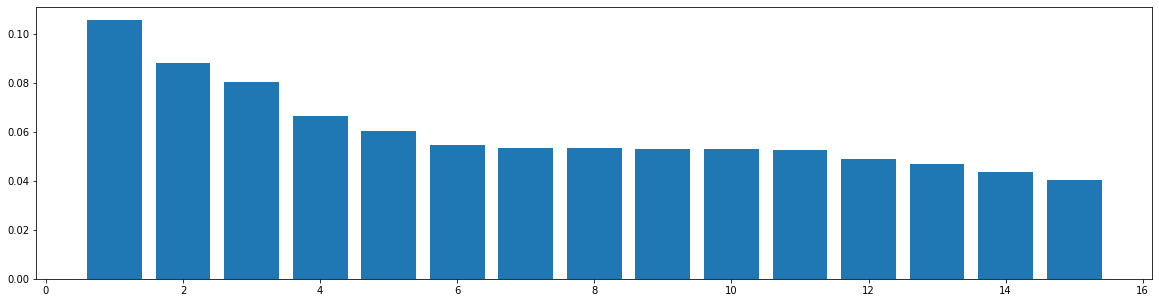

In [64]:
# Visualize the importance of each Principal Component
plt.figure(figsize=(20,5))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.show()

It seems that the first **15** components in PCA are able to explain 90% of the significance. It'd be reasonable to set the number of components to **15** in further model fitting.

---

### Logistic Regression with Pipeline

In [80]:
# Pipeline to find better models
pipe = make_pipeline(StandardScaler(), PCA(n_components=15), LogisticRegression())

# Use cross validation score to check if overfitting
print(cross_val_score(pipe, X_train, y_train, cv=5))

[0.62556701 0.6228866  0.62219014 0.62541254 0.62974422]


In [90]:
# Trying logistic regression grid search with different hyperparameters
estimators = [('scaler', StandardScaler()),
              ('model', LogisticRegression())]

pipe_logit = Pipeline(estimators)
params_logit = [
    {'model': [LogisticRegression()],
     'scaler': [None, StandardScaler(), MinMaxScaler()],
     'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
     'model__penalty': ['l1','l2']}
]

grid_logit = GridSearchCV(pipe_logit, params_logit, cv=5)
grid_logit_fitted = grid_logit.fit(X_train, y_train)

In [93]:
grid_logit_fitted.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)


It seems that a model with default setting **(L2, C=1)** and scaled data with **Standard Scaler** yields the best result.

---

### Random Forest with Grid Search

In [97]:
# Fitting different Random Forest models
pipe_rf = Pipeline([('scale', StandardScaler()), ('pca', PCA()), ('model', RandomForestClassifier())])

param_rf = [
    {'scale':[StandardScaler(), None], 'pca':[None], 'model':[RandomForestClassifier()],
    'model__max_depth':np.arange(1,30)},
    {'scale':[StandardScaler(), None], 'pca':[PCA()], 'model':[RandomForestClassifier()],
    'model__max_depth':np.arange(1,30),
    'pca__n_components':[3, 5, 10, 15, 20]}
]

grid_rf = GridSearchCV(pipe_rf, param_rf, cv=5, verbose=10, n_jobs=-1)
grid_rf_fitted = grid_rf.fit(X_train, y_train)

grid_rf_fitted.score(X_test, y_test)

Fitting 5 folds for each of 348 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

0.7395177826486601

In [103]:
grid_rf_fitted.best_estimator_

Pipeline(memory=None,
         steps=[('scale', None),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=14,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=10, n_jobs=None,
                                        oob_score=False, random_state=None,
                     

In [102]:
y_pred_rf = grid_rf_fitted.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.71      0.56      0.63     22229
           1       0.75      0.85      0.80     34343

    accuracy                           0.74     56572
   macro avg       0.73      0.71      0.71     56572
weighted avg       0.74      0.74      0.73     56572



A Random Forest model with a number of trees of **10**, with data decomposed with **5** principal components, yields the best result. It is able to achieve an **F1** score of **0.80** and accuracy rate of **74%**.

---